In [0]:
# import
import shap
import sklearn
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from utils import load_data, cindex

In [0]:
# load the dataset
X_dev, X_test, y_dev, y_test = load_data(10)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
# split the dev dataset into train and val data
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=10)

In [0]:
# X_train dataset
print("X_train shape: {}".format(X_train.shape))
X_train.head()

X_train shape: (5147, 18)


,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
1599,43.0,84.0,637.0,1.0,49.3,10.0,5.0,253.0,134.0,1.59,7.7,1.0,NaN,490.0,27.3,9.1,25.803007,34.0
2794,72.0,96.0,154.0,2.0,43.4,23.0,4.3,265.0,106.0,1.66,6.8,2.0,208.0,301.0,35.2,6.0,33.394319,112.0
1182,54.0,78.0,205.0,1.0,43.8,12.0,4.2,206.0,180.0,1.67,6.6,2.0,NaN,363.0,49.6,5.9,20.278410,34.0
6915,59.0,90.0,417.0,1.0,43.4,9.0,4.5,327.0,114.0,1.65,7.6,2.0,NaN,347.0,32.9,6.1,32.917744,78.0
500,34.0,80.0,385.0,1.0,77.7,9.0,4.1,197.0,64.0,1.74,7.3,2.0,NaN,376.0,17.0,8.2,30.743489,30.0


In [0]:
# y_train dataset
y_train.head()

1599    False
2794     True
1182    False
6915    False
500     False
Name: time, dtype: bool

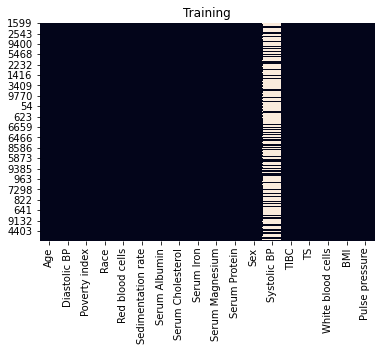

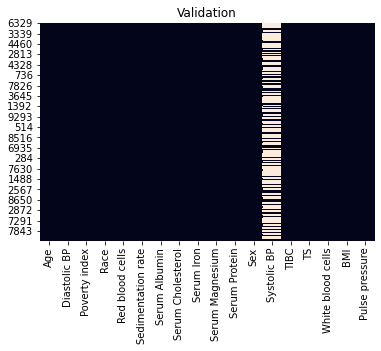

In [0]:
# missing data from training and validation dataset
sns.heatmap(X_train.isnull(), cbar=False)
plt.title("Training")
plt.show()

sns.heatmap(X_val.isnull(), cbar=False)
plt.title("Validation")
plt.show()

In [0]:
# holdout grid search to find the best parameters for the classifier
def holdoutGridSearch(classifier, X_train, y_train, X_val, y_val, 
                      hyperparameters, fixedHyperparameters = {}):
    
    # set initial values
    bestExtimator = None
    bestHyperparameters = {}
    bestScore = 0

    # get combinations of hyperparameter values
    hpValues = hyperparameters.values()
    hpCombinations = list(itertools.product(*hpValues))

    # loop through all the combinations
    for (i, parameters) in enumerate(hpCombinations, 1):

        # initialize a hyperparameter dictionary
        parametersDict = {}
        
        # fill the values in the initialized dictionary
        for (index, name) in enumerate(hyperparameters):
            parametersDict[name] = parameters[index]
        
        # create an estimator
        estimator = classifier(**parametersDict, 
                               **fixedHyperparameters)
        
        # train the model and predict the results
        estimator.fit(X_train, y_train)
        preds = estimator.predict_proba(X_val)

        # calculate the score
        estimatorScore = cindex(y_val, preds[:,1])

        # condition to update the best score along with the estimator and
        # the hyperparameters
        if estimatorScore >= bestScore:
            bestScore = estimatorScore
            bestEstimator = estimator
            bestHyperparameters = parametersDict

    # update the hyperparameters with the fixed hyperparameters
    bestHyperparameters.update(fixedHyperparameters)

    return bestEstimator, bestHyperparameters

In [0]:
# Impute values using the mean
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train)
X_train_mean_imputed = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_val_mean_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

In [0]:
# initialize the hyper parameters
hyperparameters = {
    'n_estimators': [150],
    'max_depth': [5],
    'min_samples_leaf': [5]
}

In [0]:
# generate RandomForest classifier
rf = RandomForestClassifier

# get the best estimator and best hyperparameters
bestRF, bestHyperparameters = holdoutGridSearch(rf, X_train_mean_imputed, 
                                                       y_train, X_val_mean_imputed, 
                                                       y_val, hyperparameters, 
                                                       {'random_state': 10})

print("Performance for best hyperparameters:")

# train data
y_train_best = bestRF.predict_proba(X_train_mean_imputed)[:, 1]
print("[INFO] Train C-Index: {:.4f}".format(cindex(y_train, y_train_best)))

# validation data
y_val_best = bestRF.predict_proba(X_val_mean_imputed)[:, 1]
print("[INFO] Validation C-Index: {:.4f}".format(cindex(y_val, y_val_best)))

# test data
y_test_imp = bestRF.predict_proba(X_test)[:, 1]
print("[INFO] Test C-Index: {:.4f}".format(cindex(y_test, y_test_imp)))

Performance for best hyperparameters:
[INFO] Train C-Index: 0.8090
[INFO] Validation C-Index: 0.7470
[INFO] Test C-Index: 0.7811


In [0]:
# add the risk column to the X_test dataset
# by calculating the risk values for individual columns
X_test_risk = X_test.copy(deep=True)
X_test_risk.loc[:, 'risk'] = rf_mean_imputed.predict_proba(X_test_risk)[:, 1]
X_test_risk = X_test_risk.sort_values(by='risk', ascending=False)
X_test_risk.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,risk
5493,67.0,80.0,30.0,1.0,77.7,59.0,3.4,231.0,36.0,1.40,6.3,1.0,170.0,202.0,17.8,8.4,17.029470,90.0,0.686791
2050,66.0,100.0,69.0,2.0,42.9,47.0,3.8,233.0,170.0,1.42,8.6,1.0,180.0,411.0,41.4,7.2,22.129498,80.0,0.568524
1017,65.0,98.0,16.0,1.0,49.4,30.0,3.4,124.0,129.0,1.59,7.7,1.0,184.0,293.0,44.0,5.9,30.858853,86.0,0.553479
2608,71.0,80.0,104.0,1.0,43.8,23.0,4.0,201.0,119.0,1.60,7.0,1.0,166.0,311.0,38.3,6.3,17.760766,86.0,0.530831
6337,69.0,80.0,233.0,1.0,77.7,48.0,4.2,159.0,87.0,1.81,6.9,1.0,146.0,291.0,29.9,15.2,17.931276,66.0,0.521092


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


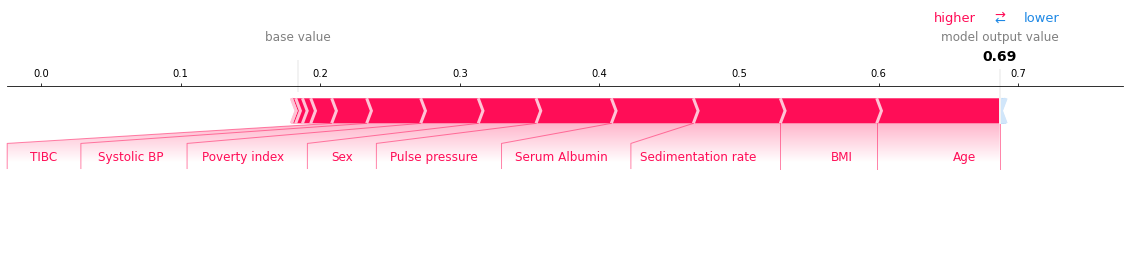

In [0]:
# plot a forceplot to determine the risk of individual attributes
explainer = shap.TreeExplainer(bestRF)
i = 0
shap_value = explainer.shap_values(X_test.loc[X_test_risk.index[i], :])[1]
shap.force_plot(explainer.expected_value[1], shap_value, feature_names=X_test.columns, matplotlib=True)

In [0]:
# initialize the shap values of individual features
shap_values = shap.TreeExplainer(bestRF).shap_values(X_test)[1]

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


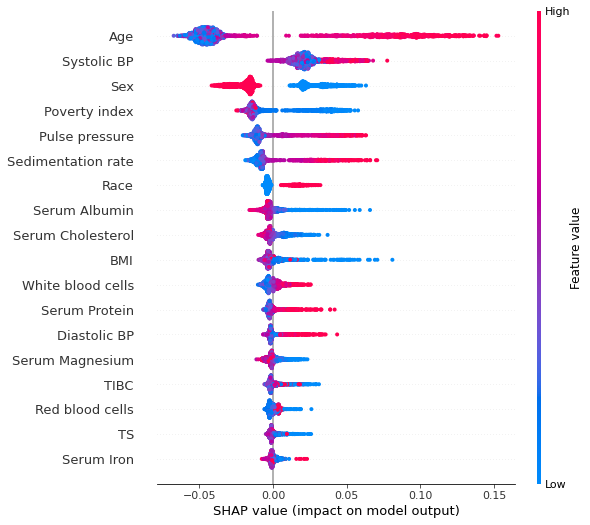

In [0]:
# plot the shap values 
shap.summary_plot(shap_values, X_test)

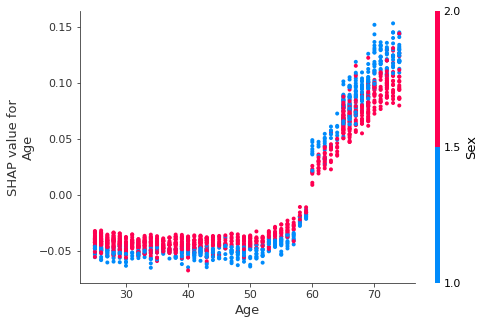

In [0]:
# plot the shap dependency between 'Age' and 'Sex' attributes
shap.dependence_plot('Age', shap_values, X_test, interaction_index='Sex')

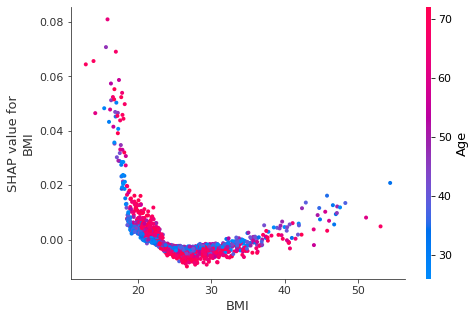

In [0]:
# plot the shap dependency between 'BMI' and 'Age' attributes
shap.dependence_plot('BMI', shap_values, X_test, interaction_index='Age')